In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import RandomOverSampler
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/atul/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load the dataset from the CSV file
data = pd.read_csv('reviews.csv')
data.head(7)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...


In [3]:
data.shape

(568454, 10)

In [4]:
#Check for and handle missing values, if any
data.dropna(subset=['Text'], inplace=True)

# Remove duplicate reviews based on the 'Text' column
data.drop_duplicates(subset=['Text'], keep='first', inplace=True)

In [5]:
data.shape

(393579, 10)

In [6]:
# Define a function for text preprocessing
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Tokenize the text (split it into words)
    tokens = word_tokenize(text)
    
    # Remove punctuation and numbers
    tokens = [word for word in tokens if word.isalpha()]
    
    # Remove stopwords (common words like 'the', 'and', 'is')
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Join the cleaned tokens back into a single text string
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

# Apply the text preprocessing function to the 'Text' column
data['CleanedText'] = data['Text'].apply(preprocess_text)

In [7]:
data.head(7)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair taffy ordered five pound bag taf...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,saltwater taffy great flavors soft chewy candy...


In [8]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define a function to perform sentiment analysis using VADER
def vader_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    if sentiment['compound'] >= 0.05:
        return "positive"
    elif sentiment['compound'] <= -0.05:
        return "negative"
    else:
        return "neutral"

# Apply VADER sentiment analysis to the 'Text' column
data['Sentiment'] = data['Text'].apply(vader_sentiment)

# Display the sentiment labels
print(data[['Text', 'Sentiment']].head())


                                                Text Sentiment
0  I have bought several of the Vitality canned d...  positive
1  Product arrived labeled as Jumbo Salted Peanut...  negative
2  This is a confection that has been around a fe...  positive
3  If you are looking for the secret ingredient i...  positive
4  Great taffy at a great price.  There was a wid...  positive


In [9]:
data.head(7)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...,negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...,positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,positive
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,positive
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair taffy ordered five pound bag taf...,positive
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,saltwater taffy great flavors soft chewy candy...,positive


positive    346326
negative     38870
neutral       8383
Name: Sentiment, dtype: int64


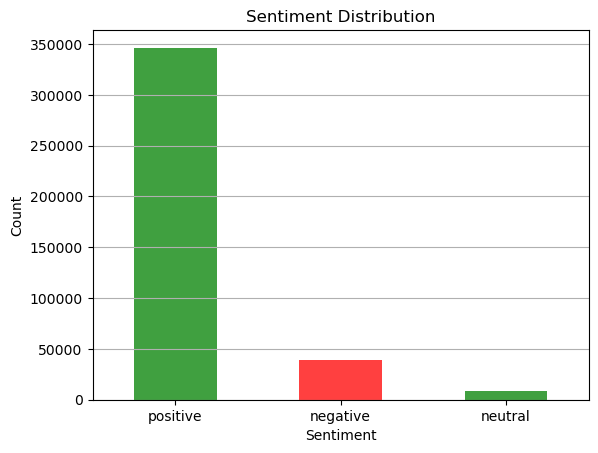

In [10]:
import matplotlib.pyplot as plt 

# Count the number of positive and negative sentiments
sentiment_counts = data['Sentiment'].value_counts()

print(sentiment_counts)

# Plot the sentiment counts as a bar graph
sentiment_counts.plot(kind='bar', color=['green', 'red'], alpha=0.75)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()

In [11]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['Text'], data['Sentiment'], test_size=0.2, random_state=42)

# Train Word2Vec model on your dataset
sentences = [text.split() for text in X_train]
vector_size = 100  # Adjust parameters as needed
word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=5, min_count=1, sg=0)

# Define a transformer for Word2Vec vectorization
class Word2VecVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model
        self.vector_size = model.vector_size
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [self.get_average_word2vec(text, self.model) for text in X]
    
    def get_average_word2vec(self, text, model):
        words = text.split()
        valid_words = [word for word in words if word in model.wv]
        if len(valid_words) > 0:
            vectors = [model.wv[word] for word in valid_words]
            return np.mean(vectors, axis=0)
        else:
            return np.zeros(self.vector_size)
        
# Transform X_train using Word2Vec
w2v_vectorizer = Word2VecVectorizer(word2vec_model)
X_train_transformed = w2v_vectorizer.transform(X_train)

# Apply RandomOverSampler to oversample the training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_transformed, y_train)

# Continue with your pipeline
pipeline = Pipeline([
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit the pipeline on the resampled training data
pipeline.fit(X_train_resampled, y_train_resampled)

# Predict on the test data (remember to transform X_test first)
X_test_transformed = w2v_vectorizer.transform(X_test)
y_pred = pipeline.predict(X_test_transformed)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
report = classification_report(y_test, y_pred)
print(report)


Accuracy: 0.6872046343818283
              precision    recall  f1-score   support

    negative       0.29      0.60      0.39      7770
     neutral       0.07      0.56      0.13      1695
    positive       0.97      0.70      0.81     69251

    accuracy                           0.69     78716
   macro avg       0.45      0.62      0.45     78716
weighted avg       0.88      0.69      0.76     78716



In [12]:
print(y_pred)


['positive' 'neutral' 'positive' ... 'positive' 'positive' 'positive']


In [22]:
# Input text to be predicted
input_text = ["I have been going to this location for a few months now. Honestly, I DO NOT recommend it.", 
              "It's going great", 
              "I ordered butter chicken with rice and it was very delicious.",
              "The restaurant chef is not terrible at cooking"]
X_input_transformed = w2v_vectorizer.transform(input_text)
# Predict sentiment
predicted_sentiment = pipeline.predict(X_input_transformed)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: ['negative' 'positive' 'positive' 'negative']
